<a href="https://colab.research.google.com/github/amanjain252002/Stock-Price-Prediction/blob/main/Deep_Learning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [65]:
StkData = pd.read_csv('Data/FB_16_21.csv')


### Data Proprocessing

In [66]:
def Dataset(Data, Date):

  Train_Data = Data['Adj Close'][Data['Date'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)

  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['Adj Close'][Data['Date'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)

  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

### Model

In [67]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [68]:
model = Model()

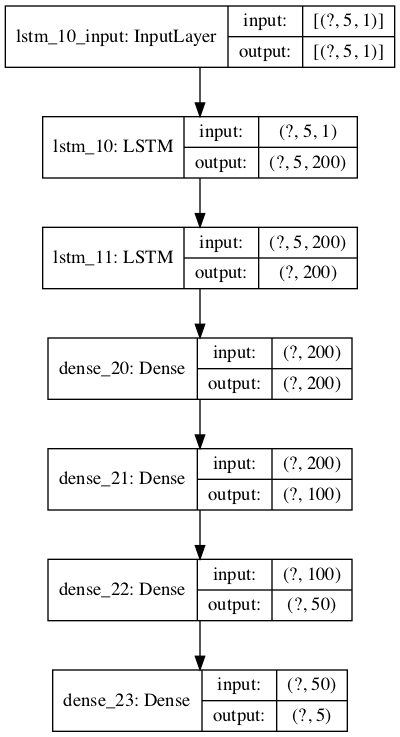

In [69]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [70]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 5, 200)            161600    
_________________________________________________________________
lstm_11 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_20 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_21 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_22 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 255       
Total params: 548,005
Trainable params: 548,005
Non-trainable params: 0
________________________________________________

### Custom Learning Rate

In [71]:
def scheduler(epoch):

  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150)
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)

  return lrate

In [72]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [73]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#Apple

In [74]:
StkData.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-09-23,127.559998,128.600006,127.300003,127.959999,127.959999,28326300
1,2016-09-26,127.370003,128.160004,126.800003,127.309998,127.309998,15064900
2,2016-09-27,127.610001,129.009995,127.430000,128.690002,128.690002,15637100
3,2016-09-28,129.210007,129.470001,128.399994,129.229996,129.229996,12047600
4,2016-09-29,129.179993,129.289993,127.550003,128.089996,128.089996,14532200


In [75]:
StkData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1243 non-null   object 
 1   Open       1243 non-null   float64
 2   High       1243 non-null   float64
 3   Low        1243 non-null   float64
 4   Close      1243 non-null   float64
 5   Adj Close  1243 non-null   float64
 6   Volume     1243 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.1+ KB


In [76]:
# Change Dtype of Date column
StkData["Date"] = pd.to_datetime(StkData["Date"])

###Split the Data into Training and Test set

In [77]:
StkData_Date = '2021-04-08'
StkData_Train_X, StkData_Train_Y, StkData_Test_X, StkData_Test_Y = Dataset(StkData, StkData_Date)

### Model Fitting

In [78]:
StkData_Model = Model()

In [79]:
StkData_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [80]:
StkData_hist = StkData_Model.fit(StkData_Train_X, StkData_Train_Y, epochs = 1000, validation_data = (StkData_Test_X, StkData_Test_Y), callbacks=[callback])

Train on 227 samples, validate on 19 samples
Epoch 1/1000
227/227 [==============================] - 8s 34ms/sample - loss: 37206.4838 - root_mean_squared_error: 192.8898 - val_loss: 114902.5625 - val_root_mean_squared_error: 338.9728
Epoch 2/1000
227/227 [==============================] - 0s 1ms/sample - loss: 37206.3562 - root_mean_squared_error: 192.8895 - val_loss: 114901.2656 - val_root_mean_squared_error: 338.9709
Epoch 3/1000
227/227 [==============================] - 0s 1ms/sample - loss: 37205.8954 - root_mean_squared_error: 192.8883 - val_loss: 114898.6016 - val_root_mean_squared_error: 338.9669
Epoch 4/1000
227/227 [==============================] - 0s 1ms/sample - loss: 37205.0907 - root_mean_squared_error: 192.8862 - val_loss: 114894.6016 - val_root_mean_squared_error: 338.9610
Epoch 5/1000
227/227 [==============================] - 0s 1ms/sample - loss: 37203.9385 - root_mean_squared_error: 192.8832 - val_loss: 114889.5547 - val_root_mean_squared_error: 338.9536
Epoch 6/1

Epoch 44/1000
227/227 [==============================] - 0s 2ms/sample - loss: 35737.4156 - root_mean_squared_error: 189.0434 - val_loss: 109459.6250 - val_root_mean_squared_error: 330.8468
Epoch 45/1000
227/227 [==============================] - 0s 2ms/sample - loss: 35643.0789 - root_mean_squared_error: 188.7938 - val_loss: 109163.1172 - val_root_mean_squared_error: 330.3984
Epoch 46/1000
227/227 [==============================] - 0s 2ms/sample - loss: 35544.2430 - root_mean_squared_error: 188.5318 - val_loss: 108858.4219 - val_root_mean_squared_error: 329.9370
Epoch 47/1000
227/227 [==============================] - 0s 2ms/sample - loss: 35442.0419 - root_mean_squared_error: 188.2606 - val_loss: 108524.8984 - val_root_mean_squared_error: 329.4312
Epoch 48/1000
227/227 [==============================] - 0s 1ms/sample - loss: 35330.7867 - root_mean_squared_error: 187.9649 - val_loss: 108163.2891 - val_root_mean_squared_error: 328.8819
Epoch 49/1000
227/227 [===========================

227/227 [==============================] - 0s 2ms/sample - loss: 80.9804 - root_mean_squared_error: 8.9989 - val_loss: 248.7208 - val_root_mean_squared_error: 15.7709
Epoch 132/1000
227/227 [==============================] - 0s 2ms/sample - loss: 78.3118 - root_mean_squared_error: 8.8494 - val_loss: 227.2434 - val_root_mean_squared_error: 15.0746
Epoch 133/1000
227/227 [==============================] - 0s 2ms/sample - loss: 74.9226 - root_mean_squared_error: 8.6558 - val_loss: 231.0518 - val_root_mean_squared_error: 15.2004
Epoch 134/1000
227/227 [==============================] - 0s 2ms/sample - loss: 73.1684 - root_mean_squared_error: 8.5539 - val_loss: 222.9043 - val_root_mean_squared_error: 14.9300
Epoch 135/1000
227/227 [==============================] - 0s 2ms/sample - loss: 71.7521 - root_mean_squared_error: 8.4707 - val_loss: 219.6282 - val_root_mean_squared_error: 14.8199
Epoch 136/1000
227/227 [==============================] - 0s 2ms/sample - loss: 70.9861 - root_mean_squar

227/227 [==============================] - 0s 2ms/sample - loss: 46.6972 - root_mean_squared_error: 6.8335 - val_loss: 104.3894 - val_root_mean_squared_error: 10.2171
Epoch 222/1000
227/227 [==============================] - 0s 2ms/sample - loss: 46.5008 - root_mean_squared_error: 6.8191 - val_loss: 103.4593 - val_root_mean_squared_error: 10.1715
Epoch 223/1000
227/227 [==============================] - 0s 2ms/sample - loss: 46.4619 - root_mean_squared_error: 6.8163 - val_loss: 101.8432 - val_root_mean_squared_error: 10.0917
Epoch 224/1000
227/227 [==============================] - 0s 2ms/sample - loss: 46.4518 - root_mean_squared_error: 6.8156 - val_loss: 103.9991 - val_root_mean_squared_error: 10.1980
Epoch 225/1000
227/227 [==============================] - 0s 2ms/sample - loss: 46.3424 - root_mean_squared_error: 6.8075 - val_loss: 84.6473 - val_root_mean_squared_error: 9.2004
Epoch 226/1000
227/227 [==============================] - 0s 2ms/sample - loss: 46.8201 - root_mean_squared

227/227 [==============================] - 0s 1ms/sample - loss: 45.1073 - root_mean_squared_error: 6.7162 - val_loss: 103.0848 - val_root_mean_squared_error: 10.1531
Epoch 312/1000
227/227 [==============================] - 0s 1ms/sample - loss: 45.0254 - root_mean_squared_error: 6.7101 - val_loss: 98.6682 - val_root_mean_squared_error: 9.9332
Epoch 313/1000
227/227 [==============================] - 0s 1ms/sample - loss: 44.9620 - root_mean_squared_error: 6.7054 - val_loss: 98.7427 - val_root_mean_squared_error: 9.9369
Epoch 314/1000
227/227 [==============================] - 0s 1ms/sample - loss: 44.9350 - root_mean_squared_error: 6.7034 - val_loss: 96.6872 - val_root_mean_squared_error: 9.8330
Epoch 315/1000
227/227 [==============================] - 0s 1ms/sample - loss: 44.9405 - root_mean_squared_error: 6.7038 - val_loss: 96.1300 - val_root_mean_squared_error: 9.8046
Epoch 316/1000
227/227 [==============================] - 0s 1ms/sample - loss: 44.9044 - root_mean_squared_error

227/227 [==============================] - 0s 1ms/sample - loss: 44.4687 - root_mean_squared_error: 6.6685 - val_loss: 106.0618 - val_root_mean_squared_error: 10.2986
Epoch 402/1000
227/227 [==============================] - 0s 1ms/sample - loss: 44.4645 - root_mean_squared_error: 6.6682 - val_loss: 103.0599 - val_root_mean_squared_error: 10.1518
Epoch 403/1000
227/227 [==============================] - 0s 1ms/sample - loss: 44.4397 - root_mean_squared_error: 6.6663 - val_loss: 102.0732 - val_root_mean_squared_error: 10.1031
Epoch 404/1000
227/227 [==============================] - 0s 1ms/sample - loss: 44.4192 - root_mean_squared_error: 6.6648 - val_loss: 93.8729 - val_root_mean_squared_error: 9.6888
Epoch 405/1000
227/227 [==============================] - 0s 1ms/sample - loss: 44.4428 - root_mean_squared_error: 6.6665 - val_loss: 91.1587 - val_root_mean_squared_error: 9.5477
Epoch 406/1000
227/227 [==============================] - 0s 1ms/sample - loss: 44.4077 - root_mean_squared_e

227/227 [==============================] - 0s 1ms/sample - loss: 44.0301 - root_mean_squared_error: 6.6355 - val_loss: 102.6411 - val_root_mean_squared_error: 10.1312
Epoch 492/1000
227/227 [==============================] - 0s 2ms/sample - loss: 44.0279 - root_mean_squared_error: 6.6354 - val_loss: 100.0115 - val_root_mean_squared_error: 10.0006
Epoch 493/1000
227/227 [==============================] - 0s 2ms/sample - loss: 44.0217 - root_mean_squared_error: 6.6349 - val_loss: 99.1240 - val_root_mean_squared_error: 9.9561
Epoch 494/1000
227/227 [==============================] - 0s 1ms/sample - loss: 44.0913 - root_mean_squared_error: 6.6401 - val_loss: 102.7200 - val_root_mean_squared_error: 10.1351
Epoch 495/1000
227/227 [==============================] - 0s 1ms/sample - loss: 44.0208 - root_mean_squared_error: 6.6348 - val_loss: 99.5881 - val_root_mean_squared_error: 9.9794
Epoch 496/1000
227/227 [==============================] - 0s 1ms/sample - loss: 44.0244 - root_mean_squared_e

227/227 [==============================] - 0s 1ms/sample - loss: 43.6274 - root_mean_squared_error: 6.6051 - val_loss: 95.9684 - val_root_mean_squared_error: 9.7963
Epoch 582/1000
227/227 [==============================] - 0s 1ms/sample - loss: 43.6500 - root_mean_squared_error: 6.6068 - val_loss: 97.8771 - val_root_mean_squared_error: 9.8933
Epoch 583/1000
227/227 [==============================] - 0s 1ms/sample - loss: 43.6147 - root_mean_squared_error: 6.6041 - val_loss: 97.4983 - val_root_mean_squared_error: 9.8741
Epoch 584/1000
227/227 [==============================] - 0s 1ms/sample - loss: 43.6417 - root_mean_squared_error: 6.6062 - val_loss: 100.3548 - val_root_mean_squared_error: 10.0177
Epoch 585/1000
227/227 [==============================] - 0s 1ms/sample - loss: 43.7320 - root_mean_squared_error: 6.6130 - val_loss: 98.3401 - val_root_mean_squared_error: 9.9167
Epoch 586/1000
227/227 [==============================] - 0s 1ms/sample - loss: 43.6826 - root_mean_squared_error

227/227 [==============================] - 0s 1ms/sample - loss: 43.4191 - root_mean_squared_error: 6.5893 - val_loss: 90.4679 - val_root_mean_squared_error: 9.5115
Epoch 672/1000
227/227 [==============================] - 0s 1ms/sample - loss: 43.5442 - root_mean_squared_error: 6.5988 - val_loss: 89.7251 - val_root_mean_squared_error: 9.4723
Epoch 673/1000
227/227 [==============================] - 0s 1ms/sample - loss: 43.4366 - root_mean_squared_error: 6.5906 - val_loss: 92.1946 - val_root_mean_squared_error: 9.6018
Epoch 674/1000
227/227 [==============================] - 0s 1ms/sample - loss: 43.3064 - root_mean_squared_error: 6.5808 - val_loss: 95.0489 - val_root_mean_squared_error: 9.7493
Epoch 675/1000
227/227 [==============================] - 0s 1ms/sample - loss: 43.3106 - root_mean_squared_error: 6.5811 - val_loss: 99.0603 - val_root_mean_squared_error: 9.9529
Epoch 676/1000
227/227 [==============================] - 0s 1ms/sample - loss: 43.2527 - root_mean_squared_error: 

227/227 [==============================] - 0s 1ms/sample - loss: 42.9319 - root_mean_squared_error: 6.5522 - val_loss: 104.1167 - val_root_mean_squared_error: 10.2038
Epoch 762/1000
227/227 [==============================] - 0s 1ms/sample - loss: 42.9728 - root_mean_squared_error: 6.5554 - val_loss: 107.6539 - val_root_mean_squared_error: 10.3756
Epoch 763/1000
227/227 [==============================] - 0s 1ms/sample - loss: 42.9564 - root_mean_squared_error: 6.5541 - val_loss: 108.4851 - val_root_mean_squared_error: 10.4156
Epoch 764/1000
227/227 [==============================] - 0s 1ms/sample - loss: 43.2097 - root_mean_squared_error: 6.5734 - val_loss: 119.1595 - val_root_mean_squared_error: 10.9160
Epoch 765/1000
227/227 [==============================] - 0s 1ms/sample - loss: 43.3905 - root_mean_squared_error: 6.5871 - val_loss: 116.8502 - val_root_mean_squared_error: 10.8097
Epoch 766/1000
227/227 [==============================] - 0s 1ms/sample - loss: 43.0945 - root_mean_squar

227/227 [==============================] - 0s 1ms/sample - loss: 42.6409 - root_mean_squared_error: 6.5300 - val_loss: 105.7908 - val_root_mean_squared_error: 10.2855
Epoch 852/1000
227/227 [==============================] - 0s 1ms/sample - loss: 42.8024 - root_mean_squared_error: 6.5424 - val_loss: 100.8426 - val_root_mean_squared_error: 10.0420
Epoch 853/1000
227/227 [==============================] - 0s 1ms/sample - loss: 42.7598 - root_mean_squared_error: 6.5391 - val_loss: 98.8068 - val_root_mean_squared_error: 9.9402
Epoch 854/1000
227/227 [==============================] - 0s 1ms/sample - loss: 42.8163 - root_mean_squared_error: 6.5434 - val_loss: 95.3705 - val_root_mean_squared_error: 9.7658
Epoch 855/1000
227/227 [==============================] - 0s 1ms/sample - loss: 42.8241 - root_mean_squared_error: 6.5440 - val_loss: 94.1226 - val_root_mean_squared_error: 9.7017
Epoch 856/1000
227/227 [==============================] - 0s 1ms/sample - loss: 42.8107 - root_mean_squared_err

227/227 [==============================] - 0s 1ms/sample - loss: 42.4415 - root_mean_squared_error: 6.5147 - val_loss: 109.9193 - val_root_mean_squared_error: 10.4842
Epoch 942/1000
227/227 [==============================] - 0s 1ms/sample - loss: 42.5548 - root_mean_squared_error: 6.5234 - val_loss: 108.8158 - val_root_mean_squared_error: 10.4315
Epoch 943/1000
227/227 [==============================] - 0s 1ms/sample - loss: 42.4230 - root_mean_squared_error: 6.5133 - val_loss: 112.9306 - val_root_mean_squared_error: 10.6269
Epoch 944/1000
227/227 [==============================] - 0s 1ms/sample - loss: 42.4838 - root_mean_squared_error: 6.5180 - val_loss: 113.7371 - val_root_mean_squared_error: 10.6648
Epoch 945/1000
227/227 [==============================] - 0s 1ms/sample - loss: 42.5931 - root_mean_squared_error: 6.5263 - val_loss: 109.4615 - val_root_mean_squared_error: 10.4624
Epoch 946/1000
227/227 [==============================] - 0s 1ms/sample - loss: 42.5512 - root_mean_squar

In [81]:
history_dict = StkData_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()


### Predicting the closing stock price

In [90]:
StkData_prediction = StkData_Model.predict(StkData_Test_X)

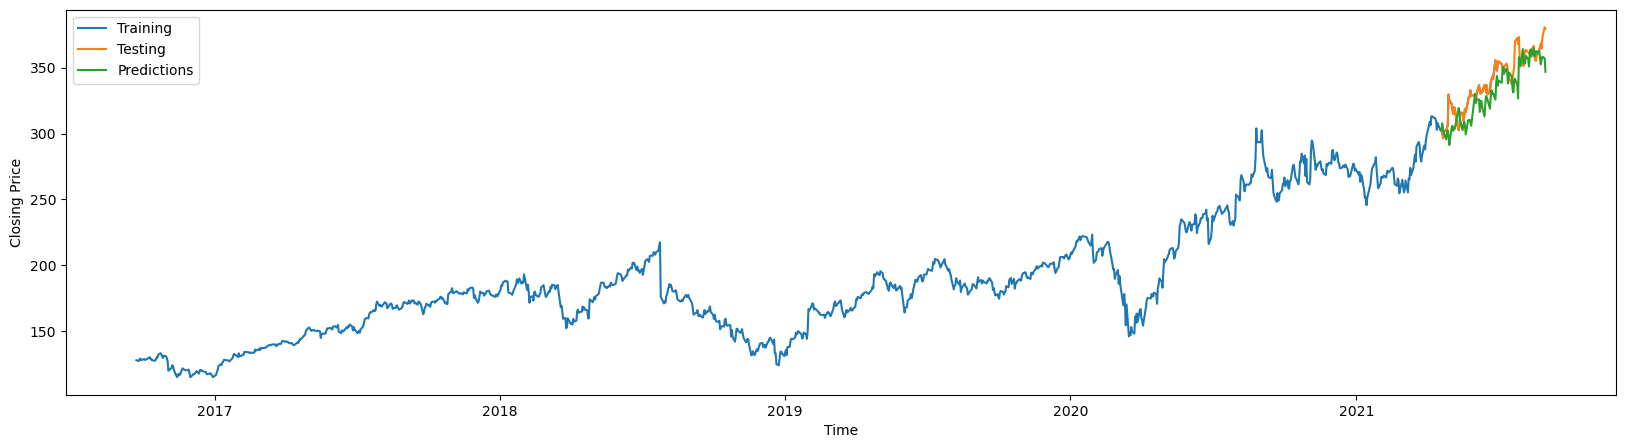

In [116]:
plt.figure(figsize=(20, 5))
plt.plot(StkData['Date'][StkData['Date'] < '2021-07-09'], StkData['Adj Close'][StkData['Date'] < '2021-07-09'], label = 'Training')
plt.plot(StkData['Date'][StkData['Date'] >= '2021-04-19'], StkData['Adj Close'][StkData['Date'] >= '2021-04-19'], label = 'Testing')
plt.plot(StkData['Date'][StkData['Date'] >= '2021-04-19'], StkData_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
plt.show()

In [92]:
rmse = math.sqrt(mean_squared_error(StkData_Test_Y.reshape(-1, 5), StkData_prediction))
mape = np.mean(np.abs(StkData_prediction - StkData_Test_Y.reshape(-1, 5))/np.abs(StkData_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 10.729777084418814
MAPE: 0.024676788873061888
